In [1]:
import cv2
import numpy as np
import requests
from scipy.stats import chi2
import matplotlib.pyplot as plt
from io import BytesIO

In [2]:
def encode_lsb(image, message):
    message += "\0"
    binary_message = ''.join(format(ord(char), '08b') for char in message)
    
    data_index = 0
    data_length = len(binary_message)
    rows, cols, channels = image.shape
    
    for row in range(rows):
        for col in range(cols):
            for channel in range(channels):
                if data_index < data_length:
                    pixel = image[row, col, channel]
                    pixel = (pixel & ~1) | int(binary_message[data_index])
                    image[row, col, channel] = pixel
                    data_index += 1
                else:
                    return image 


In [3]:
def decode_lsb(image):
    binary_message = ""
    rows, cols, channels = image.shape
    
    for row in range(rows):
        for col in range(cols):
            for channel in range(channels):
                binary_message += str(image[row, col, channel] & 1)
    
    message = "".join(chr(int(binary_message[i:i+8], 2)) for i in range(0, len(binary_message), 8))
    return message.split("\0", 1)[0]  


In [4]:
def load_image_from_url(url):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return image

In [5]:
def chi_square_test(image, title):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([image_gray], [0], None, [256], [0, 256]).flatten()
    
    even_bins = hist[::2]
    odd_bins = hist[1::2]
    expected = (even_bins + odd_bins) / 2
    
    chi_sq = np.sum(((even_bins - expected) ** 2) / (expected + 1e-10) + ((odd_bins - expected) ** 2) / (expected + 1e-10))
    p_value = chi2.sf(chi_sq, df=len(even_bins) - 1)
    
    plt.bar(range(len(hist)), hist, color='orange', alpha=0.7)
    plt.title(f'Test chi-kwadrat: {title}')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.show()
    
    return chi_sq, p_value

In [6]:
def autocorrelation_test(image, title):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    shifted = np.roll(image_gray, shift=1, axis=1)
    correlation = np.corrcoef(image_gray.flatten(), shifted.flatten())[0, 1]
    
    plt.imshow(image_gray, cmap='gray')
    plt.title(f'Test autokorelacji: {title}\nKorelacja: {correlation:.4f}')
    plt.show()
    
    return correlation

Wiadomość zakodowana.
Dekodowanie wiadomości...
Odczytana wiadomość: Mój sekret
Test chi-kwadrat dla początkowego obrazu


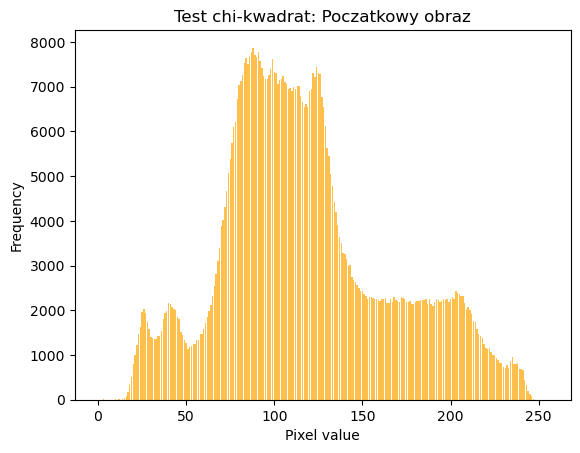

Wartosć chi-kwadrat: 579.2778930664062, p-wartość: 6.106665180669055e-59
Test chi-kwadrat dla obrazu z ukrytą wiadomością


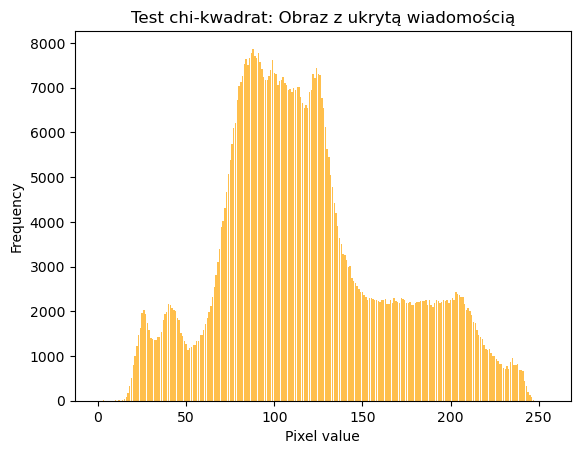

Wartość chi-kwadrat dla obrazu z ukryta wiadomoscią: 579.2778930664062, p-wartość: 6.106665180669055e-59
Test autokorelacji dla obrazu z ukrytą wiadomością


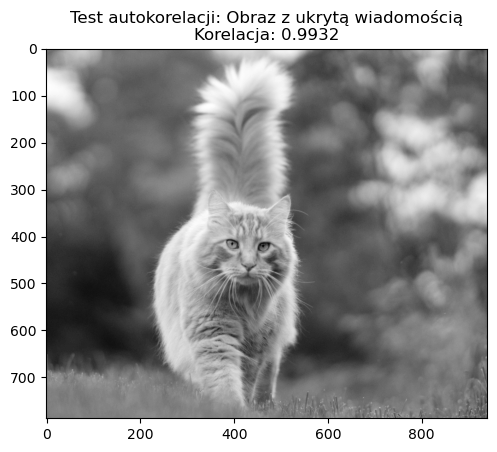

Autokorelacja piksela: 0.9931892745078083


In [7]:
if __name__ == "__main__":
    image_url = "https://petsworld.com.pl/wp-content/uploads/2023/09/7-5.jpg"
    secret_message = "Mój sekret"

    input_image = load_image_from_url(image_url)
    
    if input_image is None:
        print(f"Błąd")
    else:
        encode_lsb(input_image, secret_message)
        print("Wiadomość zakodowana.")

        print("Dekodowanie wiadomości...")
        decoded_message = decode_lsb(input_image)
        print("Odczytana wiadomość:", decoded_message)
        
        print("Test chi-kwadrat dla początkowego obrazu")
        chi_sq_orig, p_val_orig = chi_square_test(input_image, "Poczatkowy obraz")
        print(f"Wartosć chi-kwadrat: {chi_sq_orig}, p-wartość: {p_val_orig}")
        
        print("Test chi-kwadrat dla obrazu z ukrytą wiadomością")
        chi_sq_steg, p_val_steg = chi_square_test(input_image, "Obraz z ukrytą wiadomością")
        print(f"Wartość chi-kwadrat dla obrazu z ukrytą wiadomoscią: {chi_sq_steg}, p-wartość: {p_val_steg}")
        
        print("Test autokorelacji dla obrazu z ukrytą wiadomością")
        autocorrelation = autocorrelation_test(input_image, "Obraz z ukrytą wiadomością")
        print(f"Autokorelacja piksela: {autocorrelation}")
